# Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 16.01.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
import sys
sys.path.append("../../autotalker")

In [2]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scanpy as sc
import scib
import seaborn as sns

from autotalker.benchmarking import compute_benchmarking_metrics

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 58132), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 58136), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=53, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.0.18', 58146), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/c

### 1.2 Define Parameters

In [3]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
spatial_key = "spatial"

### 1.3 Run Notebook Setup

In [4]:
sc.set_figure_params(figsize=(6, 6))

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../datasets/srt_data/gold/"
figure_folder_path = f"../figures/method_benchmarking/{dataset}/"
artifact_folder_path = f"../artifacts/method_benchmarking/{dataset}/"

In [7]:
# Create required directories
os.makedirs(artifact_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)

### 1.5 Define Functions

In [8]:
def compute_combined_benchmarking_metrics(model_adata,
                                          model_name,
                                          spatial_model,
                                          run_number_list=list(np.arange(1, 11)),
                                          n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                          cell_type_key="celltype_mapped_refined"):
    benchmarking_dict_list = []
    for run_number, n_neighbors in zip(run_number_list, n_neighbors_list):
        
        # Compute Autotalker metrics
        benchmarking_dict = compute_benchmarking_metrics(adata=model_adata,
                                                         spatial_model=spatial_model,
                                                         latent_key=f"{model_name}_latent_run{run_number}",
                                                         active_gp_names_key=f"{model_name}_active_gp_names_run{run_number}",
                                                         cell_type_key=cell_type_key,
                                                         spatial_key=spatial_key,
                                                         spatial_knng_key = f"{model_name}_spatial_{n_neighbors}nng",
                                                         latent_knng_key = f"{model_name}_latent_{n_neighbors}nng",
                                                         n_neighbors=n_neighbors)

        # Compute scib metrics
        sc.pp.neighbors(adata=model_adata,
                        use_rep=f"{model_name}_latent_run{run_number}",
                        n_neighbors=n_neighbors)
        scib.me.cluster_optimal_resolution(adata=model_adata,
                                           cluster_key="cluster",
                                           label_key=cell_type_key)
        benchmarking_dict["ari"] = scib.me.ari(model_adata,
                                               cluster_key="cluster",
                                               label_key=cell_type_key)
        benchmarking_dict["clisi"] = scib.me.clisi_graph(adata=model_adata,
                                                         label_key=cell_type_key,
                                                         type_="embed",
                                                         use_rep=f"{model_name}_latent_run{run_number}")
        benchmarking_dict["nmi"] = scib.me.nmi(adata=model_adata,
                                               cluster_key="cluster",
                                               label_key=cell_type_key)
        benchmarking_dict["asw"] = scib.me.silhouette(adata=model_adata,
                                                      label_key=cell_type_key,
                                                      embed=f"{model_name}_latent_run{run_number}")
        benchmarking_dict["ilasw"] = scib.me.isolated_labels_asw(adata=model_adata,
                                                                 batch_key="sample",
                                                                 label_key=cell_type_key,
                                                                 embed=f"{model_name}_latent_run{run_number}")
        
        benchmarking_dict["model_name"] = model_name
        benchmarking_dict["run"] = run_number
        benchmarking_dict_list.append(benchmarking_dict)
    return benchmarking_dict_list

## 2. Data

In [9]:
# Load data after running all notebooks in the 'method_benchmarking' folder
adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
adata_autotalker = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")

## 3. Method Benchmarking

- Run all notebooks in the ```method_benchmarking``` directory before continuing.

### 3.1 Latent Space Comparison

In [10]:
n_neighbors = 12

# Baseline
sc.pp.neighbors(adata_pca, use_rep=f"pca_latent_run1", n_neighbors=n_neighbors)
sc.tl.umap(adata_pca, min_dist=0.3)

# Methods
run_number = 5
adata_sagenet.obsm["X_umap"] = adata_sagenet.obsm[f"sagenet_latent_run{run_number}"] # latent representation of SageNet are already UMAP features
for adata, method in zip([adata_scvi, adata_expimap, adata_deeplinc, adata_graphst, adata_autotalker],
                         ["scvi", "expimap", "deeplinc", "graphst", "autotalker"]):
    sc.pp.neighbors(adata, use_rep=f"{method}_latent_run{run_number}", n_neighbors=n_neighbors)
    sc.tl.umap(adata, min_dist=0.3)

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The 

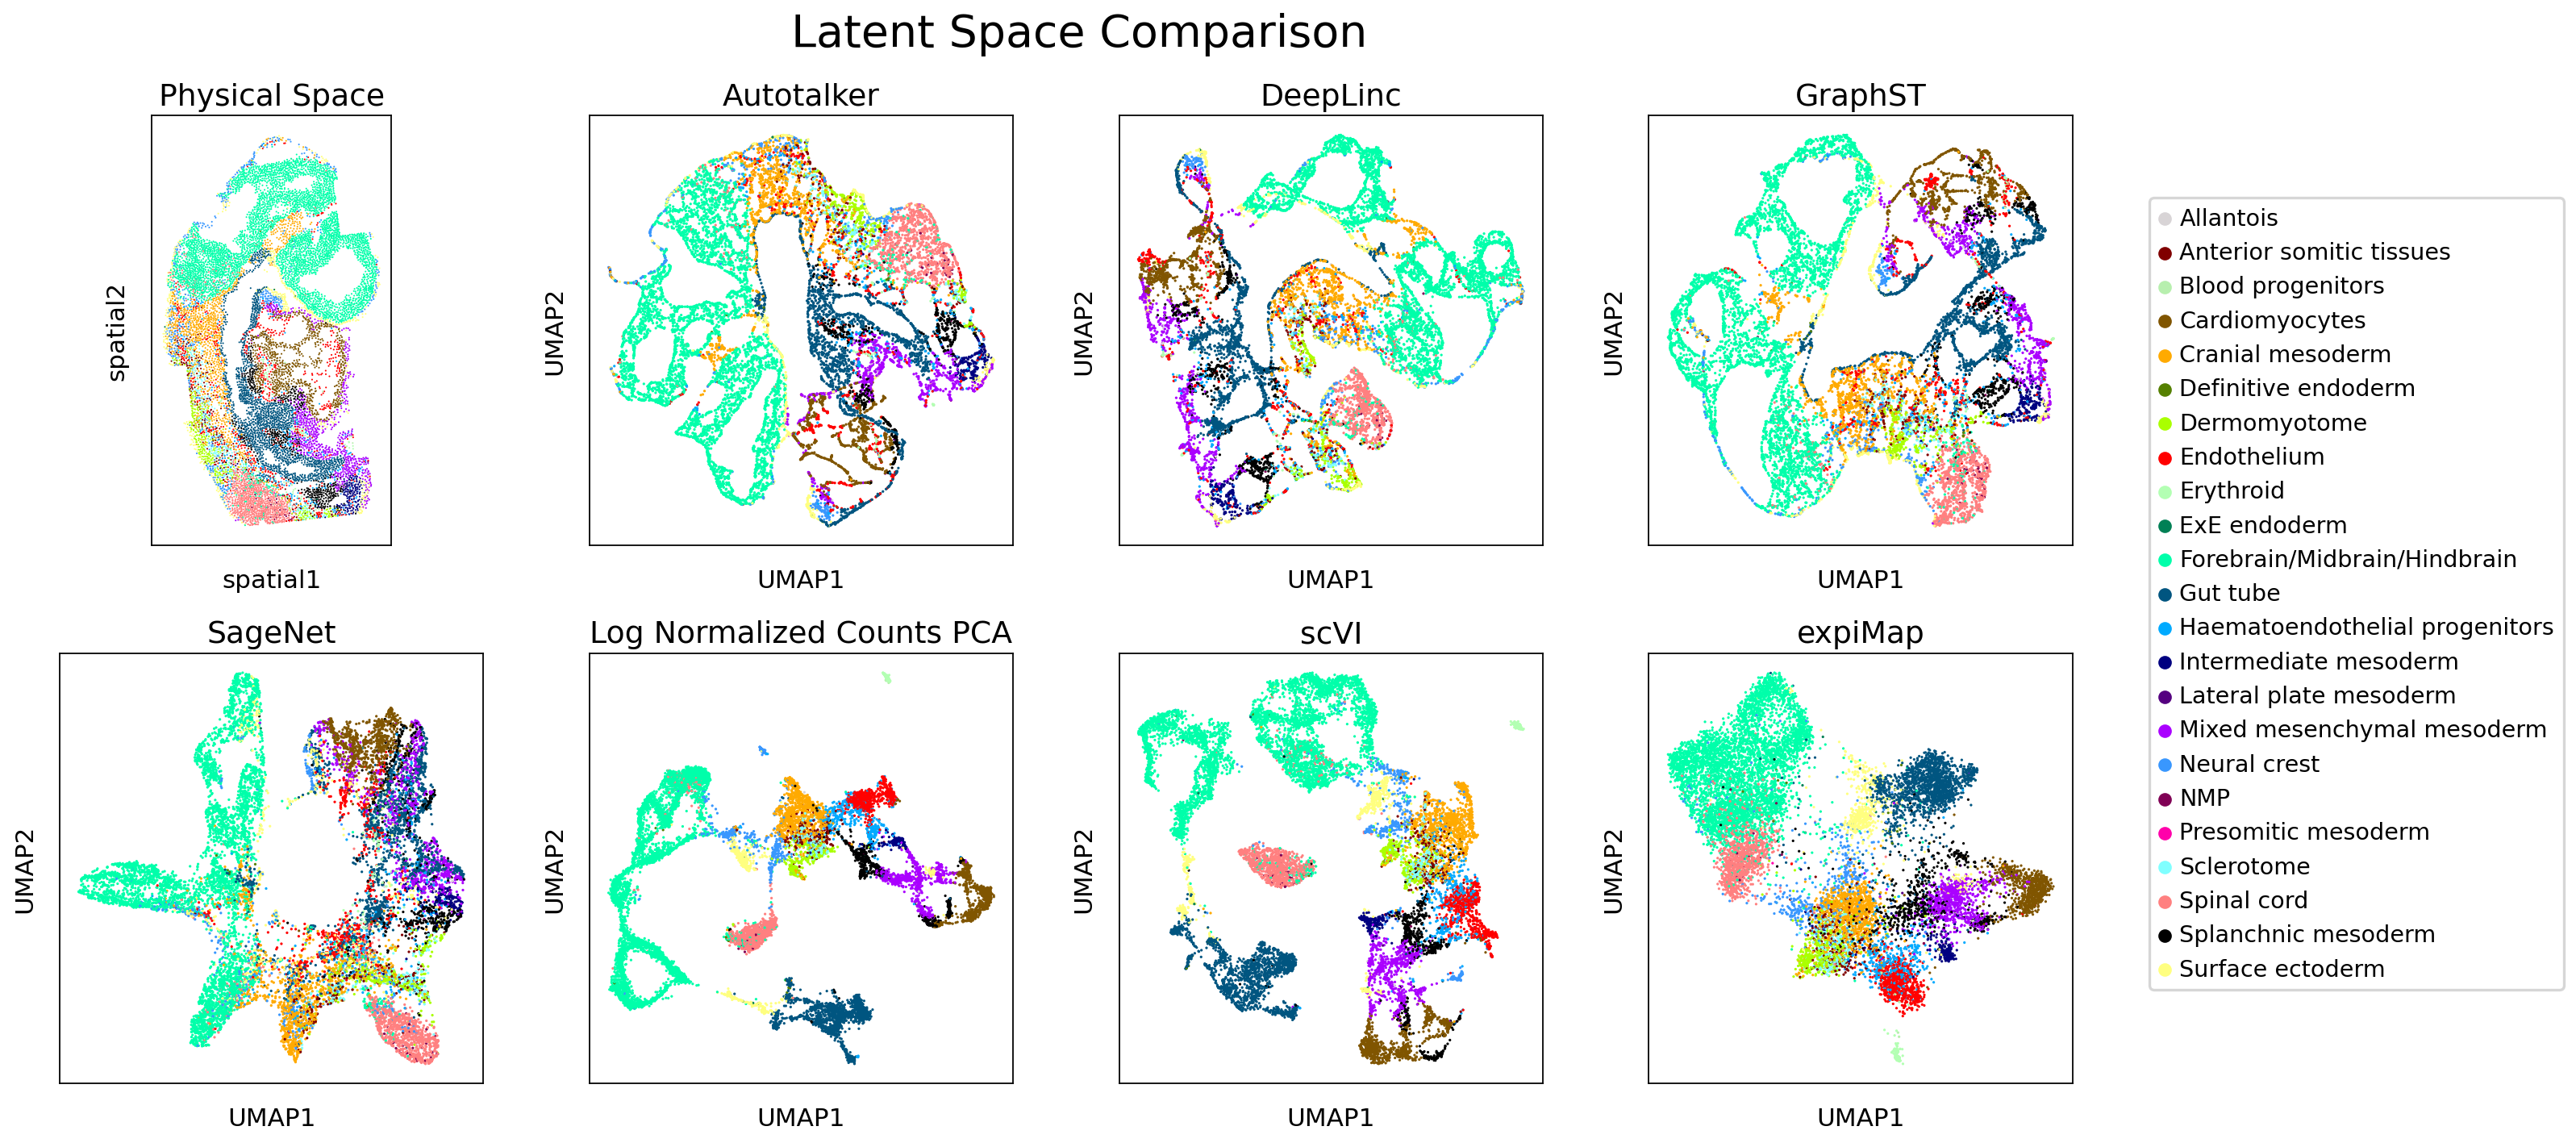

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
plt.suptitle("Latent Space Comparison", fontsize=25, x=0.575)
plt.subplots_adjust(hspace=0.25, wspace=0.25, top=0.9)
axs=axs.flatten()

sc.pl.spatial(adata=adata,
              color=[cell_type_key],
              spot_size=0.03,
              ax=axs[0],
              show=False)
axs[0].set_title("Physical Space", fontsize=17)
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(1.07, 0.845))
axs[0].get_legend().remove()
                         
for i, (adata, title) in enumerate(zip([adata_autotalker, adata_deeplinc, adata_graphst, adata_sagenet, adata_pca, adata_scvi, adata_expimap],
                                       ["Autotalker", "DeepLinc", "GraphST", "SageNet", "Log Normalized Counts PCA", "scVI", "expiMap"])):        
    sc.pl.umap(adata,
               color=[cell_type_key],
               ax=axs[i + 1],
               show=False,
               legend_loc=None)
    axs[i + 1].set_title(title, fontsize=17)

fig.savefig(f"{figure_folder_path}/latent_comparison_{current_timestamp}.png",
            bbox_inches="tight")
plt.show()

### 3.2 Benchmarking Metrics

#### 3.2.1 PCA

- Evaluate PCA of log normalized gene expression.

In [12]:
benchmarking_dict_list_pca = compute_combined_benchmarking_metrics(model_adata=adata_pca,
                                                                   model_name="pca",
                                                                   spatial_model=False,
                                                                   run_number_list=[1],
                                                                   n_neighbors_list=[12],
                                                                   cell_type_key="celltype_mapped_refined")

resolution: 0.1, nmi: 0.6695952741187797
resolution: 0.2, nmi: 0.7385439836334321
resolution: 0.3, nmi: 0.7123739081526013
resolution: 0.4, nmi: 0.7077612436556762
resolution: 0.5, nmi: 0.679065216143822
resolution: 0.6, nmi: 0.689482435231807
resolution: 0.7, nmi: 0.6772664116869933
resolution: 0.8, nmi: 0.6699740233005426
resolution: 0.9, nmi: 0.6741417815701275
resolution: 1.0, nmi: 0.6738611900287442
resolution: 1.1, nmi: 0.6715452341100905
resolution: 1.2, nmi: 0.6645002353577019
resolution: 1.3, nmi: 0.6596491788450072
resolution: 1.4, nmi: 0.6656020307195687
resolution: 1.5, nmi: 0.6586871427428685
resolution: 1.6, nmi: 0.6485736922944785
resolution: 1.7, nmi: 0.6530264394856284
resolution: 1.8, nmi: 0.6527707929669109
resolution: 1.9, nmi: 0.6466768902310875
resolution: 2.0, nmi: 0.6482103286156078
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.2
optimal score: 0.7385439836334321
isolated labels: no more than 1 batches per label
Allantois: 0.

In [13]:
benchmarking_dict_list = benchmarking_dict_list_pca

# Store to disk
with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
    pickle.dump(benchmarking_dict_list, f)

# Clean from memory
del(adata_pca)

#### 3.2.2 scVI

- Evaluate scVI.

In [14]:
benchmarking_dict_list_scvi = compute_combined_benchmarking_metrics(model_adata=adata_scvi,
                                                                    model_name="scvi",
                                                                    spatial_model=False,
                                                                    run_number_list=list(np.arange(1, 11)),
                                                                    n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                    cell_type_key="celltype_mapped_refined")

resolution: 0.1, nmi: 0.6510112755134858
resolution: 0.2, nmi: 0.6907614873560975
resolution: 0.3, nmi: 0.6887016496029861
resolution: 0.4, nmi: 0.6497561698382365
resolution: 0.5, nmi: 0.6714500541419256
resolution: 0.6, nmi: 0.6434150067935084
resolution: 0.7, nmi: 0.6377239649706704
resolution: 0.8, nmi: 0.6581777770337697
resolution: 0.9, nmi: 0.6484701775225603
resolution: 1.0, nmi: 0.63894088043837
resolution: 1.1, nmi: 0.6396198862517618
resolution: 1.2, nmi: 0.6359441530581543
resolution: 1.3, nmi: 0.627887869115528
resolution: 1.4, nmi: 0.6241053306020455
resolution: 1.5, nmi: 0.6290970674247918
resolution: 1.6, nmi: 0.6208974400448526
resolution: 1.7, nmi: 0.6177545246548721
resolution: 1.8, nmi: 0.6199699169778355
resolution: 1.9, nmi: 0.607065641579197
resolution: 2.0, nmi: 0.6144378835869146
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.2
optimal score: 0.6907614873560975
isolated labels: no more than 1 batches per label
Allantois: 0.48

In [15]:
benchmarking_dict_list += benchmarking_dict_list_scvi

# Store to disk
with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
    pickle.dump(benchmarking_dict_list, f)

# Clean from memory
del(adata_scvi)

#### 3.2.3 expiMap

- Evaluate expiMap.

In [16]:
benchmarking_dict_list_expimap = compute_combined_benchmarking_metrics(model_adata=adata_expimap,
                                                                       model_name="expimap",
                                                                       spatial_model=False,
                                                                       run_number_list=list(np.arange(1, 11)),
                                                                       n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                       cell_type_key="celltype_mapped_refined")

resolution: 0.1, nmi: 0.4089409237536028
resolution: 0.2, nmi: 0.5939560071392522
resolution: 0.3, nmi: 0.6217577026063992
resolution: 0.4, nmi: 0.6339314908378714
resolution: 0.5, nmi: 0.668790678907316
resolution: 0.6, nmi: 0.6883543171754272
resolution: 0.7, nmi: 0.6751202021837682
resolution: 0.8, nmi: 0.6871252780584086
resolution: 0.9, nmi: 0.6904399328566299
resolution: 1.0, nmi: 0.6657129548887315
resolution: 1.1, nmi: 0.6650385287457821
resolution: 1.2, nmi: 0.6634479915230966
resolution: 1.3, nmi: 0.6599662116967235
resolution: 1.4, nmi: 0.6624973479079772
resolution: 1.5, nmi: 0.6663417716304363
resolution: 1.6, nmi: 0.6604699228552408
resolution: 1.7, nmi: 0.6628162833620443
resolution: 1.8, nmi: 0.661233097396927
resolution: 1.9, nmi: 0.6481409010508983
resolution: 2.0, nmi: 0.6516956245014839
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.9
optimal score: 0.6904399328566299
isolated labels: no more than 1 batches per label
Allantois: 0.

In [17]:
benchmarking_dict_list += benchmarking_dict_list_expimap

# Store to disk
with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
    pickle.dump(benchmarking_dict_list, f)

del(adata_expimap)

#### 3.2.4 SageNet

- Evaluate SageNet.

In [18]:
benchmarking_dict_list_sagenet = compute_combined_benchmarking_metrics(model_adata=adata_sagenet,
                                                                       model_name="sagenet",
                                                                       spatial_model=True,
                                                                       run_number_list=list(np.arange(1, 11)),
                                                                       n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                       cell_type_key="celltype_mapped_refined")

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.435243026708244
resolution: 0.2, nmi: 0.4220423981254739
resolution: 0.3, nmi: 0.4258394942862083
resolution: 0.4, nmi: 0.4241234367011178
resolution: 0.5, nmi: 0.4244222442495957
resolution: 0.6, nmi: 0.41778617532690476
resolution: 0.7, nmi: 0.4167536852927635
resolution: 0.8, nmi: 0.4198220791023386
resolution: 0.9, nmi: 0.414802829197171
resolution: 1.0, nmi: 0.4159076068649655
resolution: 1.1, nmi: 0.41534075720262686
resolution: 1.2, nmi: 0.41312206515074656
resolution: 1.3, nmi: 0.4131980403405999
resolution: 1.4, nmi: 0.41201369684508293
resolution: 1.5, nmi: 0.412972997580749
resolution: 1.6, nmi: 0.4109282922913352
resolution: 1.7, nmi: 0.4120323973292932
resolution: 1.8, nmi: 0.4104986317456596
resolution: 1.9, nmi: 0.4112153567332821
resolution: 2.0, nmi: 0.4102465545226132
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.1
optimal score: 0.435243026708244
isolated labels: no more than 1 batches per label
Allantois: 

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.43449877494146855
resolution: 0.2, nmi: 0.4301266500611738
resolution: 0.3, nmi: 0.42458114004491987
resolution: 0.4, nmi: 0.41980147695023007
resolution: 0.5, nmi: 0.41816741306345506
resolution: 0.6, nmi: 0.4208032511936886
resolution: 0.7, nmi: 0.4192564038111138
resolution: 0.8, nmi: 0.41699351962742826
resolution: 0.9, nmi: 0.413877974317156
resolution: 1.0, nmi: 0.411088089124476
resolution: 1.1, nmi: 0.41104531090215635
resolution: 1.2, nmi: 0.4127471522988706
resolution: 1.3, nmi: 0.41342718574487713
resolution: 1.4, nmi: 0.41055254522922974
resolution: 1.5, nmi: 0.41001694933683924
resolution: 1.6, nmi: 0.4108726066667413
resolution: 1.7, nmi: 0.40847496374997894
resolution: 1.8, nmi: 0.4078160042249762
resolution: 1.9, nmi: 0.40853676683377066
resolution: 2.0, nmi: 0.40783036188743566
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.1
optimal score: 0.43449877494146855
isolated labels: no more than 1 batches per label


/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4299008583685908
resolution: 0.2, nmi: 0.4249054547683957
resolution: 0.3, nmi: 0.4310687624186022
resolution: 0.4, nmi: 0.43085302177328644
resolution: 0.5, nmi: 0.43125897176038763
resolution: 0.6, nmi: 0.4267054024827711
resolution: 0.7, nmi: 0.42647663771810196
resolution: 0.8, nmi: 0.42287519368808313
resolution: 0.9, nmi: 0.4239790368819667
resolution: 1.0, nmi: 0.4216781675252339
resolution: 1.1, nmi: 0.4188521814086842
resolution: 1.2, nmi: 0.41631446379089254
resolution: 1.3, nmi: 0.41107690071051917
resolution: 1.4, nmi: 0.4139080958035152
resolution: 1.5, nmi: 0.41288295103501754
resolution: 1.6, nmi: 0.41013852772870524
resolution: 1.7, nmi: 0.40939189597382886
resolution: 1.8, nmi: 0.4109300380318783
resolution: 1.9, nmi: 0.4088019009172877
resolution: 2.0, nmi: 0.4074060465356334
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.5
optimal score: 0.43125897176038763
isolated labels: no more than 1 batches per label
A

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.44769700616427827
resolution: 0.2, nmi: 0.4420882551067736
resolution: 0.3, nmi: 0.4415252610562144
resolution: 0.4, nmi: 0.4424933913411654
resolution: 0.5, nmi: 0.43943139528056463
resolution: 0.6, nmi: 0.4370118010658175
resolution: 0.7, nmi: 0.43585937565378186
resolution: 0.8, nmi: 0.43219904102587897
resolution: 0.9, nmi: 0.4316971769113877
resolution: 1.0, nmi: 0.42935914543461595
resolution: 1.1, nmi: 0.4241001185894743
resolution: 1.2, nmi: 0.4256926397184642
resolution: 1.3, nmi: 0.42220842739541536
resolution: 1.4, nmi: 0.4189741100855894
resolution: 1.5, nmi: 0.4179328575260402
resolution: 1.6, nmi: 0.4177469651431739
resolution: 1.7, nmi: 0.418305704139844
resolution: 1.8, nmi: 0.4169652600335593
resolution: 1.9, nmi: 0.41744646698008875
resolution: 2.0, nmi: 0.41460468446554927
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.1
optimal score: 0.44769700616427827
isolated labels: no more than 1 batches per label
All

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4297530834308708
resolution: 0.2, nmi: 0.4312233246349578
resolution: 0.3, nmi: 0.4341176001567135
resolution: 0.4, nmi: 0.42755720618960197
resolution: 0.5, nmi: 0.42433852341586364
resolution: 0.6, nmi: 0.42509410382146257
resolution: 0.7, nmi: 0.4249124488321233
resolution: 0.8, nmi: 0.41755388602694254
resolution: 0.9, nmi: 0.4147440253063477
resolution: 1.0, nmi: 0.41325733815937316
resolution: 1.1, nmi: 0.41466655443909806
resolution: 1.2, nmi: 0.40757390078085953
resolution: 1.3, nmi: 0.4074445884152421
resolution: 1.4, nmi: 0.40383585175278197
resolution: 1.5, nmi: 0.4034809938216165
resolution: 1.6, nmi: 0.40315156538377633
resolution: 1.7, nmi: 0.4031004793331312
resolution: 1.8, nmi: 0.40086453730155125
resolution: 1.9, nmi: 0.40025411456310217
resolution: 2.0, nmi: 0.40038192591278554
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.3
optimal score: 0.4341176001567135
isolated labels: no more than 1 batches per label

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4298416181877117
resolution: 0.2, nmi: 0.42395814301811324
resolution: 0.3, nmi: 0.4233904525945515
resolution: 0.4, nmi: 0.4278432955372158
resolution: 0.5, nmi: 0.4253351540445095
resolution: 0.6, nmi: 0.4221388203013403
resolution: 0.7, nmi: 0.422560374661525
resolution: 0.8, nmi: 0.41943806150407004
resolution: 0.9, nmi: 0.4154142704763214
resolution: 1.0, nmi: 0.414409383673192
resolution: 1.1, nmi: 0.41246909243370633
resolution: 1.2, nmi: 0.40781292363369537
resolution: 1.3, nmi: 0.40706798347735956
resolution: 1.4, nmi: 0.4048254719012892
resolution: 1.5, nmi: 0.40554772235802505
resolution: 1.6, nmi: 0.4052958072342976
resolution: 1.7, nmi: 0.4048882283714075
resolution: 1.8, nmi: 0.40214236834904027
resolution: 1.9, nmi: 0.39995075554231496
resolution: 2.0, nmi: 0.39951415543447055
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.1
optimal score: 0.4298416181877117
isolated labels: no more than 1 batches per label
Alla

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4259340338703439
resolution: 0.2, nmi: 0.4328535901398143
resolution: 0.3, nmi: 0.42947797545427524
resolution: 0.4, nmi: 0.42446923581276713
resolution: 0.5, nmi: 0.4224612261412073
resolution: 0.6, nmi: 0.41759208626038885
resolution: 0.7, nmi: 0.4156210505900744
resolution: 0.8, nmi: 0.41421903982878133
resolution: 0.9, nmi: 0.4148451885236148
resolution: 1.0, nmi: 0.41224242520089144
resolution: 1.1, nmi: 0.4123182221943398
resolution: 1.2, nmi: 0.40986709664177745
resolution: 1.3, nmi: 0.4078827415372747
resolution: 1.4, nmi: 0.40731452169273685
resolution: 1.5, nmi: 0.40588036323306426
resolution: 1.6, nmi: 0.40280672523248406
resolution: 1.7, nmi: 0.401070591285958
resolution: 1.8, nmi: 0.401585514729333
resolution: 1.9, nmi: 0.4002862447627122
resolution: 2.0, nmi: 0.40057119804647545
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.2
optimal score: 0.4328535901398143
isolated labels: no more than 1 batches per label
All

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4185190357743547
resolution: 0.2, nmi: 0.4176859940552574
resolution: 0.3, nmi: 0.41880067834102586
resolution: 0.4, nmi: 0.4163840453450041
resolution: 0.5, nmi: 0.41291140299874274
resolution: 0.6, nmi: 0.4128667892875616
resolution: 0.7, nmi: 0.4101206223050816
resolution: 0.8, nmi: 0.41165504260886654
resolution: 0.9, nmi: 0.40760425404515976
resolution: 1.0, nmi: 0.41066764822233864
resolution: 1.1, nmi: 0.4069799332082549
resolution: 1.2, nmi: 0.40805656385291256
resolution: 1.3, nmi: 0.4071644682896187
resolution: 1.4, nmi: 0.40560040871833747
resolution: 1.5, nmi: 0.404171668217758
resolution: 1.6, nmi: 0.39955763804895605
resolution: 1.7, nmi: 0.4007090467030271
resolution: 1.8, nmi: 0.40059297786214965
resolution: 1.9, nmi: 0.39807172750973424
resolution: 2.0, nmi: 0.3980130941618913
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.3
optimal score: 0.41880067834102586
isolated labels: no more than 1 batches per label
A

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4360462731658547
resolution: 0.2, nmi: 0.4380508161728271
resolution: 0.3, nmi: 0.43147715711388335
resolution: 0.4, nmi: 0.42713189372640625
resolution: 0.5, nmi: 0.4179603676065158
resolution: 0.6, nmi: 0.4234048227347954
resolution: 0.7, nmi: 0.4184875905431724
resolution: 0.8, nmi: 0.41585068194529046
resolution: 0.9, nmi: 0.4132681273888197
resolution: 1.0, nmi: 0.4134619092584133
resolution: 1.1, nmi: 0.40909369735820805
resolution: 1.2, nmi: 0.40772214602604107
resolution: 1.3, nmi: 0.4068543500137342
resolution: 1.4, nmi: 0.4062198819072048
resolution: 1.5, nmi: 0.4077134790009603
resolution: 1.6, nmi: 0.4068570868738758
resolution: 1.7, nmi: 0.4049667033674782
resolution: 1.8, nmi: 0.4029269085953221
resolution: 1.9, nmi: 0.40247081506170856
resolution: 2.0, nmi: 0.40223006254744315
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.2
optimal score: 0.4380508161728271
isolated labels: no more than 1 batches per label
Alla

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4413870509060596
resolution: 0.2, nmi: 0.43394323802506074
resolution: 0.3, nmi: 0.4262070582144658
resolution: 0.4, nmi: 0.4212683231409887
resolution: 0.5, nmi: 0.42113588133531404
resolution: 0.6, nmi: 0.41478810841586067
resolution: 0.7, nmi: 0.41289109791883827
resolution: 0.8, nmi: 0.40892352180188307
resolution: 0.9, nmi: 0.4121467569711015
resolution: 1.0, nmi: 0.4057238928490337
resolution: 1.1, nmi: 0.4034144751388553
resolution: 1.2, nmi: 0.3998395791087295
resolution: 1.3, nmi: 0.39929545187214704
resolution: 1.4, nmi: 0.39814381560419443
resolution: 1.5, nmi: 0.3982836426310399
resolution: 1.6, nmi: 0.396472960641293
resolution: 1.7, nmi: 0.39805877285862845
resolution: 1.8, nmi: 0.3952559693320698
resolution: 1.9, nmi: 0.3969456271353921
resolution: 2.0, nmi: 0.39408480027658255
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.1
optimal score: 0.4413870509060596
isolated labels: no more than 1 batches per label
All

In [19]:
benchmarking_dict_list += benchmarking_dict_list_sagenet

# Store to disk
with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
    pickle.dump(benchmarking_dict_list, f)
    
del(adata_sagenet)

#### 3.2.5 DeepLinc

- Evaluate DeepLinc.

In [20]:
benchmarking_dict_list_deeplinc = compute_combined_benchmarking_metrics(model_adata=adata_deeplinc,
                                                                        model_name="deeplinc",
                                                                        spatial_model=True,
                                                                        run_number_list=list(np.arange(1, 11)),
                                                                        n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                        cell_type_key="celltype_mapped_refined")

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.43625205848769655
resolution: 0.2, nmi: 0.4256497541226183
resolution: 0.3, nmi: 0.4354678447390657
resolution: 0.4, nmi: 0.4485325608489123
resolution: 0.5, nmi: 0.4475305564455195
resolution: 0.6, nmi: 0.44626262488014123
resolution: 0.7, nmi: 0.4494230780105263
resolution: 0.8, nmi: 0.4456513556761488
resolution: 0.9, nmi: 0.4431506552761424
resolution: 1.0, nmi: 0.4444155442721347
resolution: 1.1, nmi: 0.4439504771040337
resolution: 1.2, nmi: 0.4466912134575003
resolution: 1.3, nmi: 0.4407771257462492
resolution: 1.4, nmi: 0.4483105432868993
resolution: 1.5, nmi: 0.4520939220675786
resolution: 1.6, nmi: 0.4489948038021931
resolution: 1.7, nmi: 0.4467223731441045
resolution: 1.8, nmi: 0.4514085671173903
resolution: 1.9, nmi: 0.4491425220828568
resolution: 2.0, nmi: 0.45359524591392275
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 2.0
optimal score: 0.45359524591392275
isolated labels: no more than 1 batches per label
Allanto

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.41754042813827297
resolution: 0.2, nmi: 0.43234902197484865
resolution: 0.3, nmi: 0.4433913982853898
resolution: 0.4, nmi: 0.4304758788832483
resolution: 0.5, nmi: 0.4420848548273954
resolution: 0.6, nmi: 0.44035862187015024
resolution: 0.7, nmi: 0.4462801481258109
resolution: 0.8, nmi: 0.4436694781824643
resolution: 0.9, nmi: 0.4477603003616837
resolution: 1.0, nmi: 0.4466935330564486
resolution: 1.1, nmi: 0.45044861299895705
resolution: 1.2, nmi: 0.4539531016466902
resolution: 1.3, nmi: 0.45388129212139466
resolution: 1.4, nmi: 0.4538113942345524
resolution: 1.5, nmi: 0.4554665868658289
resolution: 1.6, nmi: 0.45497971186623615
resolution: 1.7, nmi: 0.45604915006672675
resolution: 1.8, nmi: 0.45106554457542286
resolution: 1.9, nmi: 0.45217957749499677
resolution: 2.0, nmi: 0.4522064072462398
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.7
optimal score: 0.45604915006672675
isolated labels: no more than 1 batches per label
A

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4259855235342221
resolution: 0.2, nmi: 0.4437795915799509
resolution: 0.3, nmi: 0.45272565981240187
resolution: 0.4, nmi: 0.452511726950073
resolution: 0.5, nmi: 0.44875686375491997
resolution: 0.6, nmi: 0.4474671817167912
resolution: 0.7, nmi: 0.45199591803614514
resolution: 0.8, nmi: 0.4478736086171818
resolution: 0.9, nmi: 0.45416074012928376
resolution: 1.0, nmi: 0.4513717644858348
resolution: 1.1, nmi: 0.45514614343822946
resolution: 1.2, nmi: 0.45524801509075324
resolution: 1.3, nmi: 0.4509032948328198
resolution: 1.4, nmi: 0.45398367654166427
resolution: 1.5, nmi: 0.45397626811506897
resolution: 1.6, nmi: 0.45177030679728675
resolution: 1.7, nmi: 0.4556660624622754
resolution: 1.8, nmi: 0.4605025389666072
resolution: 1.9, nmi: 0.45156636431321323
resolution: 2.0, nmi: 0.45508402649245877
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.8
optimal score: 0.4605025389666072
isolated labels: no more than 1 batches per label
A

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.428395152450733
resolution: 0.2, nmi: 0.4570630362125895
resolution: 0.3, nmi: 0.4429018755406801
resolution: 0.4, nmi: 0.4435057516577116
resolution: 0.5, nmi: 0.4506689019480596
resolution: 0.6, nmi: 0.46196194340548064
resolution: 0.7, nmi: 0.4496381405507686
resolution: 0.8, nmi: 0.4514412455605427
resolution: 0.9, nmi: 0.4551477241434562
resolution: 1.0, nmi: 0.450577724157521
resolution: 1.1, nmi: 0.46231474196764155
resolution: 1.2, nmi: 0.459259660950851
resolution: 1.3, nmi: 0.45560418148955284
resolution: 1.4, nmi: 0.4577250378191906
resolution: 1.5, nmi: 0.4589577304166906
resolution: 1.6, nmi: 0.45511933775398805
resolution: 1.7, nmi: 0.4551312103470226
resolution: 1.8, nmi: 0.4578432720374869
resolution: 1.9, nmi: 0.4558437287128268
resolution: 2.0, nmi: 0.4592412935071807
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.1
optimal score: 0.46231474196764155
isolated labels: no more than 1 batches per label
Allantois

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.43252121467496346
resolution: 0.2, nmi: 0.4525184163226129
resolution: 0.3, nmi: 0.43892311321676836
resolution: 0.4, nmi: 0.4493014403105487
resolution: 0.5, nmi: 0.4449095346904666
resolution: 0.6, nmi: 0.4398373933701989
resolution: 0.7, nmi: 0.4400063253279432
resolution: 0.8, nmi: 0.4416937555988147
resolution: 0.9, nmi: 0.44671773032772716
resolution: 1.0, nmi: 0.4455482176919103
resolution: 1.1, nmi: 0.4413886860562275
resolution: 1.2, nmi: 0.4472035588401237
resolution: 1.3, nmi: 0.4551682645408674
resolution: 1.4, nmi: 0.44611042798184963
resolution: 1.5, nmi: 0.4524792260423195
resolution: 1.6, nmi: 0.44797941524393964
resolution: 1.7, nmi: 0.4487761065516157
resolution: 1.8, nmi: 0.4476795576925684
resolution: 1.9, nmi: 0.4516881052235206
resolution: 2.0, nmi: 0.4514805281977422
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.3
optimal score: 0.4551682645408674
isolated labels: no more than 1 batches per label
Allant

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.43015294155153055
resolution: 0.2, nmi: 0.44837810677021833
resolution: 0.3, nmi: 0.45525849250647893
resolution: 0.4, nmi: 0.4489413494710715
resolution: 0.5, nmi: 0.45032679436146034
resolution: 0.6, nmi: 0.4523216686219526
resolution: 0.7, nmi: 0.46383947410361076
resolution: 0.8, nmi: 0.47385508131887544
resolution: 0.9, nmi: 0.47245617773066934
resolution: 1.0, nmi: 0.4663732486005634
resolution: 1.1, nmi: 0.4591090033959406
resolution: 1.2, nmi: 0.4627215021560881
resolution: 1.3, nmi: 0.46514413417717826
resolution: 1.4, nmi: 0.46832603537303813
resolution: 1.5, nmi: 0.46423397412509415
resolution: 1.6, nmi: 0.4610812739747328
resolution: 1.7, nmi: 0.4620468809669192
resolution: 1.8, nmi: 0.4648618800715756
resolution: 1.9, nmi: 0.46476947463101104
resolution: 2.0, nmi: 0.4625771117144722
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.8
optimal score: 0.47385508131887544
isolated labels: no more than 1 batches per label

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.41921664438099887
resolution: 0.2, nmi: 0.4540634144214613
resolution: 0.3, nmi: 0.45344811725990447
resolution: 0.4, nmi: 0.46518850631918546
resolution: 0.5, nmi: 0.46849803600363843
resolution: 0.6, nmi: 0.466736759354967
resolution: 0.7, nmi: 0.48461850553910224
resolution: 0.8, nmi: 0.4617678182855542
resolution: 0.9, nmi: 0.47060919460825185
resolution: 1.0, nmi: 0.4558112292323247
resolution: 1.1, nmi: 0.47182282885318727
resolution: 1.2, nmi: 0.465025547503624
resolution: 1.3, nmi: 0.4722571975565193
resolution: 1.4, nmi: 0.46791179357588947
resolution: 1.5, nmi: 0.46907492166926595
resolution: 1.6, nmi: 0.4736059646170952
resolution: 1.7, nmi: 0.4693661571129118
resolution: 1.8, nmi: 0.46387700621360495
resolution: 1.9, nmi: 0.4637776418262836
resolution: 2.0, nmi: 0.4657788353798787
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.7
optimal score: 0.48461850553910224
isolated labels: no more than 1 batches per label
Al

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.46743559558799075
resolution: 0.2, nmi: 0.4763647129434446
resolution: 0.3, nmi: 0.45797747516157666
resolution: 0.4, nmi: 0.4731427341583808
resolution: 0.5, nmi: 0.4731511306224201
resolution: 0.6, nmi: 0.48175104578762235
resolution: 0.7, nmi: 0.47272726328333464
resolution: 0.8, nmi: 0.4851992868720977
resolution: 0.9, nmi: 0.49057059259380764
resolution: 1.0, nmi: 0.47696702275701064
resolution: 1.1, nmi: 0.4758798275216994
resolution: 1.2, nmi: 0.4794694429409881
resolution: 1.3, nmi: 0.48081997234065316
resolution: 1.4, nmi: 0.47662301463113543
resolution: 1.5, nmi: 0.4725148007199507
resolution: 1.6, nmi: 0.4753255789274685
resolution: 1.7, nmi: 0.4775727644970678
resolution: 1.8, nmi: 0.4774409554694519
resolution: 1.9, nmi: 0.4727399873652412
resolution: 2.0, nmi: 0.4696953440866152
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.9
optimal score: 0.49057059259380764
isolated labels: no more than 1 batches per label
Al

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4005640355751902
resolution: 0.2, nmi: 0.4756742692010997
resolution: 0.3, nmi: 0.48239493629475255
resolution: 0.4, nmi: 0.4878085167846949
resolution: 0.5, nmi: 0.4917750266618409
resolution: 0.6, nmi: 0.5081376340815978
resolution: 0.7, nmi: 0.515722927446216
resolution: 0.8, nmi: 0.5144085455493467
resolution: 0.9, nmi: 0.5033770237386803
resolution: 1.0, nmi: 0.5049238679308895
resolution: 1.1, nmi: 0.5012277433431551
resolution: 1.2, nmi: 0.5064116932974697
resolution: 1.3, nmi: 0.5068434585632492
resolution: 1.4, nmi: 0.4986450511131698
resolution: 1.5, nmi: 0.4963264193315245
resolution: 1.6, nmi: 0.49690085899902126
resolution: 1.7, nmi: 0.5010729812315667
resolution: 1.8, nmi: 0.49322584628551014
resolution: 1.9, nmi: 0.494671992029163
resolution: 2.0, nmi: 0.49294560404819776
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.7
optimal score: 0.515722927446216
isolated labels: no more than 1 batches per label
Allantois:

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.47643743098241614
resolution: 0.2, nmi: 0.4896185774986417
resolution: 0.3, nmi: 0.4732667499494021
resolution: 0.4, nmi: 0.46422500452326537
resolution: 0.5, nmi: 0.4776100461708798
resolution: 0.6, nmi: 0.4904998209696007
resolution: 0.7, nmi: 0.49169880892607337
resolution: 0.8, nmi: 0.49061886206030547
resolution: 0.9, nmi: 0.492992421614684
resolution: 1.0, nmi: 0.49231831903269524
resolution: 1.1, nmi: 0.4939955873320325
resolution: 1.2, nmi: 0.48877255505663825
resolution: 1.3, nmi: 0.48581490099534586
resolution: 1.4, nmi: 0.4856902851680263
resolution: 1.5, nmi: 0.4883674414309419
resolution: 1.6, nmi: 0.48301644221201206
resolution: 1.7, nmi: 0.48527106652852087
resolution: 1.8, nmi: 0.4832940459747977
resolution: 1.9, nmi: 0.48306600390789833
resolution: 2.0, nmi: 0.4843909249927905
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.1
optimal score: 0.4939955873320325
isolated labels: no more than 1 batches per label
Al

In [22]:
benchmarking_dict_list += benchmarking_dict_list_deeplinc

# Store to disk
with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
    pickle.dump(benchmarking_dict_list, f)

del(adata_deeplinc)

#### 3.2.6 GraphST

- Evaluate GraphST.

In [23]:
benchmarking_dict_list_graphst = compute_combined_benchmarking_metrics(model_adata=adata_graphst,
                                                                       model_name="graphst",
                                                                       spatial_model=True,
                                                                       run_number_list=list(np.arange(1, 11)),
                                                                       n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                       cell_type_key="celltype_mapped_refined")

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.47294341303416404
resolution: 0.2, nmi: 0.5082340559483084
resolution: 0.3, nmi: 0.49906530741147354
resolution: 0.4, nmi: 0.5094257792119968
resolution: 0.5, nmi: 0.49035188147410563
resolution: 0.6, nmi: 0.495388757730002
resolution: 0.7, nmi: 0.509367494202366
resolution: 0.8, nmi: 0.5156310098876428
resolution: 0.9, nmi: 0.5135098190487541
resolution: 1.0, nmi: 0.5153474501652963
resolution: 1.1, nmi: 0.5163188509217957
resolution: 1.2, nmi: 0.5201195888181004
resolution: 1.3, nmi: 0.5160459958310807
resolution: 1.4, nmi: 0.5097811534362477
resolution: 1.5, nmi: 0.5037713771932556
resolution: 1.6, nmi: 0.5060875187838292
resolution: 1.7, nmi: 0.5028119532042805
resolution: 1.8, nmi: 0.5013521929676243
resolution: 1.9, nmi: 0.4948849702291706
resolution: 2.0, nmi: 0.49421120562105975
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.2
optimal score: 0.5201195888181004
isolated labels: no more than 1 batches per label
Allantois

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4718722436144923
resolution: 0.2, nmi: 0.49944201302417573
resolution: 0.3, nmi: 0.490270967923295
resolution: 0.4, nmi: 0.5000599585313501
resolution: 0.5, nmi: 0.5004562891991952
resolution: 0.6, nmi: 0.5101055516328261
resolution: 0.7, nmi: 0.5038966964750895
resolution: 0.8, nmi: 0.5052387730320496
resolution: 0.9, nmi: 0.5104331739820483
resolution: 1.0, nmi: 0.5023381592724095
resolution: 1.1, nmi: 0.49886008013639743
resolution: 1.2, nmi: 0.5000744412911918
resolution: 1.3, nmi: 0.49858459584811077
resolution: 1.4, nmi: 0.49444908546162736
resolution: 1.5, nmi: 0.49091107786628196
resolution: 1.6, nmi: 0.4877720693422733
resolution: 1.7, nmi: 0.492721098957908
resolution: 1.8, nmi: 0.4871137950194876
resolution: 1.9, nmi: 0.49054809431090857
resolution: 2.0, nmi: 0.4885772517661604
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.9
optimal score: 0.5104331739820483
isolated labels: no more than 1 batches per label
Allanto

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.45720153862381474
resolution: 0.2, nmi: 0.4645855434534198
resolution: 0.3, nmi: 0.4574090862556836
resolution: 0.4, nmi: 0.45763745392541066
resolution: 0.5, nmi: 0.46234071033486784
resolution: 0.6, nmi: 0.4630138543094601
resolution: 0.7, nmi: 0.4544361150672426
resolution: 0.8, nmi: 0.46812889671231706
resolution: 0.9, nmi: 0.4699754396118572
resolution: 1.0, nmi: 0.4642324840648115
resolution: 1.1, nmi: 0.4708117578680994
resolution: 1.2, nmi: 0.46603088653243663
resolution: 1.3, nmi: 0.47275305882693425
resolution: 1.4, nmi: 0.4659927744251104
resolution: 1.5, nmi: 0.46832749504408416
resolution: 1.6, nmi: 0.4687502748521729
resolution: 1.7, nmi: 0.46937371053187077
resolution: 1.8, nmi: 0.46860054299928905
resolution: 1.9, nmi: 0.47113142274143444
resolution: 2.0, nmi: 0.4689344208865178
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.3
optimal score: 0.47275305882693425
isolated labels: no more than 1 batches per label


/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4732087104197076
resolution: 0.2, nmi: 0.44969621623141565
resolution: 0.3, nmi: 0.44067454829403313
resolution: 0.4, nmi: 0.4564037176092106
resolution: 0.5, nmi: 0.4460356427043488
resolution: 0.6, nmi: 0.47022642023314193
resolution: 0.7, nmi: 0.47452524929769435
resolution: 0.8, nmi: 0.46633333367478136
resolution: 0.9, nmi: 0.47198173034454677
resolution: 1.0, nmi: 0.46628141140905077
resolution: 1.1, nmi: 0.46323053698101524
resolution: 1.2, nmi: 0.4670982265722796
resolution: 1.3, nmi: 0.4688160123055765
resolution: 1.4, nmi: 0.473454819966626
resolution: 1.5, nmi: 0.47400462221295114
resolution: 1.6, nmi: 0.47202322106048833
resolution: 1.7, nmi: 0.4623176615919341
resolution: 1.8, nmi: 0.46958538101892006
resolution: 1.9, nmi: 0.4637127044111396
resolution: 2.0, nmi: 0.4625480186077124
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.7
optimal score: 0.47452524929769435
isolated labels: no more than 1 batches per label


/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4374147356651466
resolution: 0.2, nmi: 0.45784003338387647
resolution: 0.3, nmi: 0.45669401931486053
resolution: 0.4, nmi: 0.46503892125002977
resolution: 0.5, nmi: 0.4534129128734463
resolution: 0.6, nmi: 0.4627032549392983
resolution: 0.7, nmi: 0.45591169993232084
resolution: 0.8, nmi: 0.4426469169057617
resolution: 0.9, nmi: 0.45151999421625855
resolution: 1.0, nmi: 0.4615985397763381
resolution: 1.1, nmi: 0.46608179426261404
resolution: 1.2, nmi: 0.4684466915989623
resolution: 1.3, nmi: 0.470248777944757
resolution: 1.4, nmi: 0.4620754942303415
resolution: 1.5, nmi: 0.46611866784774864
resolution: 1.6, nmi: 0.46176010138843704
resolution: 1.7, nmi: 0.4588710073600321
resolution: 1.8, nmi: 0.4578345530244512
resolution: 1.9, nmi: 0.4667349150695297
resolution: 2.0, nmi: 0.4628640377742666
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.3
optimal score: 0.470248777944757
isolated labels: no more than 1 batches per label
Allan

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.46193627468544596
resolution: 0.2, nmi: 0.45001567267643283
resolution: 0.3, nmi: 0.45355467670060307
resolution: 0.4, nmi: 0.4505437630666579
resolution: 0.5, nmi: 0.45678408772839846
resolution: 0.6, nmi: 0.45678789815725396
resolution: 0.7, nmi: 0.47075310956747723
resolution: 0.8, nmi: 0.4579043654240191
resolution: 0.9, nmi: 0.45575720347879267
resolution: 1.0, nmi: 0.46984289294188103
resolution: 1.1, nmi: 0.4696304767927493
resolution: 1.2, nmi: 0.46630153476291036
resolution: 1.3, nmi: 0.46882887577100973
resolution: 1.4, nmi: 0.4676612123084808
resolution: 1.5, nmi: 0.4634057136944043
resolution: 1.6, nmi: 0.4714742556440511
resolution: 1.7, nmi: 0.4675386777444225
resolution: 1.8, nmi: 0.4682660133848753
resolution: 1.9, nmi: 0.46712779312680563
resolution: 2.0, nmi: 0.4658070296660106
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.6
optimal score: 0.4714742556440511
isolated labels: no more than 1 batches per label


/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4872595903967088
resolution: 0.2, nmi: 0.4470486577164392
resolution: 0.3, nmi: 0.45344137248004246
resolution: 0.4, nmi: 0.449260231795719
resolution: 0.5, nmi: 0.4504336956279632
resolution: 0.6, nmi: 0.4575459572272312
resolution: 0.7, nmi: 0.46062107741490593
resolution: 0.8, nmi: 0.46776330897458945
resolution: 0.9, nmi: 0.4676703564230559
resolution: 1.0, nmi: 0.464683386753392
resolution: 1.1, nmi: 0.46007338933852365
resolution: 1.2, nmi: 0.46253793924895714
resolution: 1.3, nmi: 0.4661750326630773
resolution: 1.4, nmi: 0.46681605203597526
resolution: 1.5, nmi: 0.46757140151948745
resolution: 1.6, nmi: 0.4659143501284298
resolution: 1.7, nmi: 0.46532819027666933
resolution: 1.8, nmi: 0.4596391680175556
resolution: 1.9, nmi: 0.46362183341812047
resolution: 2.0, nmi: 0.4612150396262231
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.1
optimal score: 0.4872595903967088
isolated labels: no more than 1 batches per label
Alla

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.42638635764657346
resolution: 0.2, nmi: 0.44189652495428855
resolution: 0.3, nmi: 0.4507869523818096
resolution: 0.4, nmi: 0.4496723603700508
resolution: 0.5, nmi: 0.4781868261835685
resolution: 0.6, nmi: 0.46446444492883016
resolution: 0.7, nmi: 0.4608016086902114
resolution: 0.8, nmi: 0.46657226451068484
resolution: 0.9, nmi: 0.47404461216615074
resolution: 1.0, nmi: 0.46232974645885916
resolution: 1.1, nmi: 0.46091385245478944
resolution: 1.2, nmi: 0.46380697724461056
resolution: 1.3, nmi: 0.4619775916290322
resolution: 1.4, nmi: 0.46103536895035746
resolution: 1.5, nmi: 0.45627933404230375
resolution: 1.6, nmi: 0.4566679214842205
resolution: 1.7, nmi: 0.4579264059905968
resolution: 1.8, nmi: 0.45708775890262976
resolution: 1.9, nmi: 0.4656173197518335
resolution: 2.0, nmi: 0.4618172313890545
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.5
optimal score: 0.4781868261835685
isolated labels: no more than 1 batches per label


/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4672323664342714
resolution: 0.2, nmi: 0.45737268447697815
resolution: 0.3, nmi: 0.4552756827048862
resolution: 0.4, nmi: 0.46237870230817524
resolution: 0.5, nmi: 0.4752840205691638
resolution: 0.6, nmi: 0.4504674285438188
resolution: 0.7, nmi: 0.47828658493857096
resolution: 0.8, nmi: 0.4802511285262441
resolution: 0.9, nmi: 0.47701114831992836
resolution: 1.0, nmi: 0.45567993428771486
resolution: 1.1, nmi: 0.47483610017326916
resolution: 1.2, nmi: 0.4784706901683784
resolution: 1.3, nmi: 0.46309820542322866
resolution: 1.4, nmi: 0.46296352611823643
resolution: 1.5, nmi: 0.46557646893818233
resolution: 1.6, nmi: 0.46284307320046225
resolution: 1.7, nmi: 0.46269849733299506
resolution: 1.8, nmi: 0.4655378014180632
resolution: 1.9, nmi: 0.4610586858635294
resolution: 2.0, nmi: 0.4599907557902425
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.8
optimal score: 0.4802511285262441
isolated labels: no more than 1 batches per label


/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4433681883897872
resolution: 0.2, nmi: 0.4479015171701779
resolution: 0.3, nmi: 0.45188175848602163
resolution: 0.4, nmi: 0.45081683044376464
resolution: 0.5, nmi: 0.4557816947918472
resolution: 0.6, nmi: 0.4654380040932378
resolution: 0.7, nmi: 0.45453392371493523
resolution: 0.8, nmi: 0.46608672990650196
resolution: 0.9, nmi: 0.45728462962761546
resolution: 1.0, nmi: 0.4675641385854077
resolution: 1.1, nmi: 0.4628076084237652
resolution: 1.2, nmi: 0.46869704717602134
resolution: 1.3, nmi: 0.46665317458653804
resolution: 1.4, nmi: 0.4598388093426093
resolution: 1.5, nmi: 0.46675327893467955
resolution: 1.6, nmi: 0.4654428591829344
resolution: 1.7, nmi: 0.46466405926161625
resolution: 1.8, nmi: 0.4624055187509363
resolution: 1.9, nmi: 0.4578701210481247
resolution: 2.0, nmi: 0.4621254611247963
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.2
optimal score: 0.46869704717602134
isolated labels: no more than 1 batches per label
A

In [24]:
benchmarking_dict_list += benchmarking_dict_list_graphst

# Store to disk
with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
    pickle.dump(benchmarking_dict_list, f)

del(adata_graphst)

#### 3.2.7 Autotalker

- Evaluate Autotalker.

In [25]:
benchmarking_dict_list_autotalker = compute_combined_benchmarking_metrics(model_adata=adata_autotalker,
                                                                          model_name="autotalker",
                                                                          spatial_model=True,
                                                                          run_number_list=list(np.arange(1, 11)),
                                                                          n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                                          cell_type_key="celltype_mapped_refined")

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4183732079097059
resolution: 0.2, nmi: 0.4228731176128337
resolution: 0.3, nmi: 0.42210970897262806
resolution: 0.4, nmi: 0.4304868573398589
resolution: 0.5, nmi: 0.42763913414247595
resolution: 0.6, nmi: 0.43612635393248383
resolution: 0.7, nmi: 0.44364626266583757
resolution: 0.8, nmi: 0.4514885386604637
resolution: 0.9, nmi: 0.44759054233914203
resolution: 1.0, nmi: 0.44645534086329575
resolution: 1.1, nmi: 0.4404541708661758
resolution: 1.2, nmi: 0.44358355167930696
resolution: 1.3, nmi: 0.44282531991065827
resolution: 1.4, nmi: 0.443760436110624
resolution: 1.5, nmi: 0.4433499428628667
resolution: 1.6, nmi: 0.44297862660616427
resolution: 1.7, nmi: 0.4417211148076205
resolution: 1.8, nmi: 0.4413128745622056
resolution: 1.9, nmi: 0.4407304052953068
resolution: 2.0, nmi: 0.4431679518916272
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.8
optimal score: 0.4514885386604637
isolated labels: no more than 1 batches per label
All

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4006021691822774
resolution: 0.2, nmi: 0.42009744598123966
resolution: 0.3, nmi: 0.4377046226651237
resolution: 0.4, nmi: 0.4225362872931388
resolution: 0.5, nmi: 0.4287254996327716
resolution: 0.6, nmi: 0.4250383297457686
resolution: 0.7, nmi: 0.4364839844171675
resolution: 0.8, nmi: 0.4404716019935482
resolution: 0.9, nmi: 0.44262193466887256
resolution: 1.0, nmi: 0.44276117037696305
resolution: 1.1, nmi: 0.4415247018117864
resolution: 1.2, nmi: 0.4435754640286375
resolution: 1.3, nmi: 0.44003064643959516
resolution: 1.4, nmi: 0.43790996517263975
resolution: 1.5, nmi: 0.441875101579846
resolution: 1.6, nmi: 0.44190161612255613
resolution: 1.7, nmi: 0.4386498075680026
resolution: 1.8, nmi: 0.43667903692299004
resolution: 1.9, nmi: 0.4401749295173408
resolution: 2.0, nmi: 0.43789887699804986
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.2
optimal score: 0.4435754640286375
isolated labels: no more than 1 batches per label
Alla

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4181384958976344
resolution: 0.2, nmi: 0.41753862165192746
resolution: 0.3, nmi: 0.4075112116721231
resolution: 0.4, nmi: 0.41621559531387986
resolution: 0.5, nmi: 0.4248861766636317
resolution: 0.6, nmi: 0.42856903227032234
resolution: 0.7, nmi: 0.4269101172612886
resolution: 0.8, nmi: 0.4264802835181031
resolution: 0.9, nmi: 0.42162420579229387
resolution: 1.0, nmi: 0.42617477699831524
resolution: 1.1, nmi: 0.43141292622651484
resolution: 1.2, nmi: 0.42791277104040365
resolution: 1.3, nmi: 0.4320418631013303
resolution: 1.4, nmi: 0.4321398277611463
resolution: 1.5, nmi: 0.43206596701533756
resolution: 1.6, nmi: 0.4308462727705386
resolution: 1.7, nmi: 0.4290791504972529
resolution: 1.8, nmi: 0.429604592288886
resolution: 1.9, nmi: 0.4302658645707101
resolution: 2.0, nmi: 0.4283116463839072
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.4
optimal score: 0.4321398277611463
isolated labels: no more than 1 batches per label
Alla

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.40416228629808204
resolution: 0.2, nmi: 0.41585881628429155
resolution: 0.3, nmi: 0.40614325479316854
resolution: 0.4, nmi: 0.43063855696469716
resolution: 0.5, nmi: 0.43973976288665867
resolution: 0.6, nmi: 0.43242955077121864
resolution: 0.7, nmi: 0.4289900766579939
resolution: 0.8, nmi: 0.43023393335868304
resolution: 0.9, nmi: 0.43143516932507114
resolution: 1.0, nmi: 0.4337402733917795
resolution: 1.1, nmi: 0.4386248969242617
resolution: 1.2, nmi: 0.43222493485646396
resolution: 1.3, nmi: 0.4298850855139439
resolution: 1.4, nmi: 0.4286096484275224
resolution: 1.5, nmi: 0.4320104709753804
resolution: 1.6, nmi: 0.429354564678359
resolution: 1.7, nmi: 0.4330145340593157
resolution: 1.8, nmi: 0.43002024863388727
resolution: 1.9, nmi: 0.4304144678120861
resolution: 2.0, nmi: 0.4307839262655781
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.5
optimal score: 0.43973976288665867
isolated labels: no more than 1 batches per label
A

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4117352326589412
resolution: 0.2, nmi: 0.4130093876769493
resolution: 0.3, nmi: 0.42276760898685317
resolution: 0.4, nmi: 0.4262705635742348
resolution: 0.5, nmi: 0.422557815011353
resolution: 0.6, nmi: 0.4290257966207218
resolution: 0.7, nmi: 0.428786106626507
resolution: 0.8, nmi: 0.4317636627523557
resolution: 0.9, nmi: 0.4346473600887269
resolution: 1.0, nmi: 0.428909170503281
resolution: 1.1, nmi: 0.43706828810238224
resolution: 1.2, nmi: 0.43758323813432876
resolution: 1.3, nmi: 0.43540094348179786
resolution: 1.4, nmi: 0.43768111255179915
resolution: 1.5, nmi: 0.43351522576865814
resolution: 1.6, nmi: 0.43588615164996813
resolution: 1.7, nmi: 0.4277660438839897
resolution: 1.8, nmi: 0.4348805213009914
resolution: 1.9, nmi: 0.4332135923731778
resolution: 2.0, nmi: 0.4320187104699988
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.4
optimal score: 0.43768111255179915
isolated labels: no more than 1 batches per label
Allant

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.3817661182977309
resolution: 0.2, nmi: 0.41600484830854045
resolution: 0.3, nmi: 0.41253800522215717
resolution: 0.4, nmi: 0.41913454642285886
resolution: 0.5, nmi: 0.42885545769029143
resolution: 0.6, nmi: 0.41799669962765995
resolution: 0.7, nmi: 0.41948718783553773
resolution: 0.8, nmi: 0.42179526901814396
resolution: 0.9, nmi: 0.42314926197666947
resolution: 1.0, nmi: 0.4216625843979689
resolution: 1.1, nmi: 0.42872150882891424
resolution: 1.2, nmi: 0.4307998095111244
resolution: 1.3, nmi: 0.4347250910745346
resolution: 1.4, nmi: 0.43671705772026426
resolution: 1.5, nmi: 0.4277956790109382
resolution: 1.6, nmi: 0.42888346184069537
resolution: 1.7, nmi: 0.43308175287135436
resolution: 1.8, nmi: 0.43154316913639695
resolution: 1.9, nmi: 0.4327826248060786
resolution: 2.0, nmi: 0.42915997190927285
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.4
optimal score: 0.43671705772026426
isolated labels: no more than 1 batches per la

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4019328246808521
resolution: 0.2, nmi: 0.4169727864188128
resolution: 0.3, nmi: 0.4124848368163827
resolution: 0.4, nmi: 0.42253677523822863
resolution: 0.5, nmi: 0.43122124706699444
resolution: 0.6, nmi: 0.42138059559280433
resolution: 0.7, nmi: 0.4261071058755713
resolution: 0.8, nmi: 0.4257974044710724
resolution: 0.9, nmi: 0.4249700278239043
resolution: 1.0, nmi: 0.42980462199071384
resolution: 1.1, nmi: 0.4251970026780128
resolution: 1.2, nmi: 0.4296939269866432
resolution: 1.3, nmi: 0.4316305638650551
resolution: 1.4, nmi: 0.4300009365097767
resolution: 1.5, nmi: 0.42615764868096684
resolution: 1.6, nmi: 0.4289167349507867
resolution: 1.7, nmi: 0.43701481331303055
resolution: 1.8, nmi: 0.4280910331775037
resolution: 1.9, nmi: 0.4335914126665122
resolution: 2.0, nmi: 0.4325837337540851
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.7
optimal score: 0.43701481331303055
isolated labels: no more than 1 batches per label
Alla

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.39546778614222705
resolution: 0.2, nmi: 0.412239705996427
resolution: 0.3, nmi: 0.42472190085030964
resolution: 0.4, nmi: 0.4152084611892799
resolution: 0.5, nmi: 0.42997513429041895
resolution: 0.6, nmi: 0.4192612110768337
resolution: 0.7, nmi: 0.4210150683740481
resolution: 0.8, nmi: 0.43049503210813916
resolution: 0.9, nmi: 0.4292013902250326
resolution: 1.0, nmi: 0.42720619851363284
resolution: 1.1, nmi: 0.4300404522746084
resolution: 1.2, nmi: 0.42639297259422115
resolution: 1.3, nmi: 0.43300402958674417
resolution: 1.4, nmi: 0.431591584716038
resolution: 1.5, nmi: 0.4306365334360131
resolution: 1.6, nmi: 0.428106335999337
resolution: 1.7, nmi: 0.4327692749183467
resolution: 1.8, nmi: 0.4358437723780492
resolution: 1.9, nmi: 0.43379980983643357
resolution: 2.0, nmi: 0.4344778341862826
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.8
optimal score: 0.4358437723780492
isolated labels: no more than 1 batches per label
Allant

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.4013330153348024
resolution: 0.2, nmi: 0.42456194774765993
resolution: 0.3, nmi: 0.4170734827623969
resolution: 0.4, nmi: 0.4195715697930191
resolution: 0.5, nmi: 0.42225090026385687
resolution: 0.6, nmi: 0.4234817819032249
resolution: 0.7, nmi: 0.42890539786676135
resolution: 0.8, nmi: 0.4326338367661688
resolution: 0.9, nmi: 0.42633636040457046
resolution: 1.0, nmi: 0.423135370145117
resolution: 1.1, nmi: 0.4319053312519534
resolution: 1.2, nmi: 0.43343874168748786
resolution: 1.3, nmi: 0.43265152951482844
resolution: 1.4, nmi: 0.43344465749257455
resolution: 1.5, nmi: 0.43292357935301307
resolution: 1.6, nmi: 0.43397727900258415
resolution: 1.7, nmi: 0.4356579127988328
resolution: 1.8, nmi: 0.4321442278761005
resolution: 1.9, nmi: 0.4317151588086034
resolution: 2.0, nmi: 0.42784752615841526
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 1.7
optimal score: 0.4356579127988328
isolated labels: no more than 1 batches per label
Al

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


resolution: 0.1, nmi: 0.40998335800238295
resolution: 0.2, nmi: 0.4361633080636591
resolution: 0.3, nmi: 0.42322611194993126
resolution: 0.4, nmi: 0.41702613103842673
resolution: 0.5, nmi: 0.4298377575719708
resolution: 0.6, nmi: 0.4239363334342372
resolution: 0.7, nmi: 0.42362331474980214
resolution: 0.8, nmi: 0.4284492126602185
resolution: 0.9, nmi: 0.41578733792713846
resolution: 1.0, nmi: 0.42028710845479805
resolution: 1.1, nmi: 0.42706010208885076
resolution: 1.2, nmi: 0.43241882239037194
resolution: 1.3, nmi: 0.4297720529091605
resolution: 1.4, nmi: 0.4309752569291269
resolution: 1.5, nmi: 0.4292047006520866
resolution: 1.6, nmi: 0.4312679725334493
resolution: 1.7, nmi: 0.4304515185638931
resolution: 1.8, nmi: 0.4295481977226337
resolution: 1.9, nmi: 0.42475385717377123
resolution: 2.0, nmi: 0.4252130246793966
optimised clustering against celltype_mapped_refined
optimal cluster resolution: 0.2
optimal score: 0.4361633080636591
isolated labels: no more than 1 batches per label
Al

In [26]:
benchmarking_dict_list += benchmarking_dict_list_autotalker

# Store to disk
with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
    pickle.dump(benchmarking_dict_list, f)

del(adata_autotalker)

#### 3.2.8 Summary

In [12]:
# Read complete benchmarking data from disk
with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "rb") as f:
    benchmarking_dict_list = pickle.load(f)

In [13]:
df = pd.DataFrame(benchmarking_dict_list)
df.head()

,germse,cca,ari,clisi,nmi,asw,ilasw,model_name,run,gcd,mlnmi,cad,arclisi
0,0.172732,0.940289,0.585147,0.997536,0.738544,0.529471,0.518086,pca,1,NaN,NaN,NaN,NaN
1,0.234641,0.928516,0.455237,0.996078,0.690761,0.496104,0.512826,scvi,1,NaN,NaN,NaN,NaN
2,0.234850,0.928305,0.447414,0.995613,0.678037,0.495165,0.512414,scvi,2,NaN,NaN,NaN,NaN
3,0.234839,0.930842,0.457386,0.995490,0.693209,0.489391,0.510720,scvi,3,NaN,NaN,NaN,NaN
4,0.235120,0.928587,0.450370,0.996254,0.697966,0.489104,0.508395,scvi,4,NaN,NaN,NaN,NaN


In [14]:
# Compute metric means over all runs
mean_df = df.groupby("model_name").mean()

columns = ["gcd",
           "mlnmi",
           "cad",
           "arclisi",
           "germse",
           "cca",
           "ari",
           "clisi",
           "nmi",
           "asw",
           "ilasw"]

rows = ["autotalker",
        "deeplinc",
        "graphst",
        "sagenet",
        "pca",
        "scvi",
        "expimap"]

mean_df = mean_df[columns]
mean_df = mean_df.reindex(rows)

mean_df

,gcd,mlnmi,cad,arclisi,germse,cca,ari,clisi,nmi,asw,ilasw
model_name,,,,,,,,,,,
autotalker,103.100420,0.857777,48.806560,0.046962,0.230450,0.863257,0.109329,0.981888,0.438602,0.498249,0.509119
deeplinc,221.750618,0.774386,144.181286,0.092479,0.247812,0.857088,0.166374,0.980669,0.474639,0.464128,0.502446
graphst,164.808594,0.813911,142.043404,0.087568,0.224117,0.886916,0.183225,0.986678,0.483395,0.510070,0.514236
sagenet,295.204388,0.683729,241.144677,0.218854,0.298615,0.798590,0.176499,0.967795,0.434375,0.415661,0.482191
pca,NaN,NaN,NaN,NaN,0.172732,0.940289,0.585147,0.997536,0.738544,0.529471,0.518086
scvi,NaN,NaN,NaN,NaN,0.234824,0.929545,0.446840,0.995712,0.688061,0.494902,0.511574
expimap,NaN,NaN,NaN,NaN,0.224434,0.869390,0.565593,0.953460,0.683803,0.496440,0.503666


##### 3.2.8.1 Metrics Plot

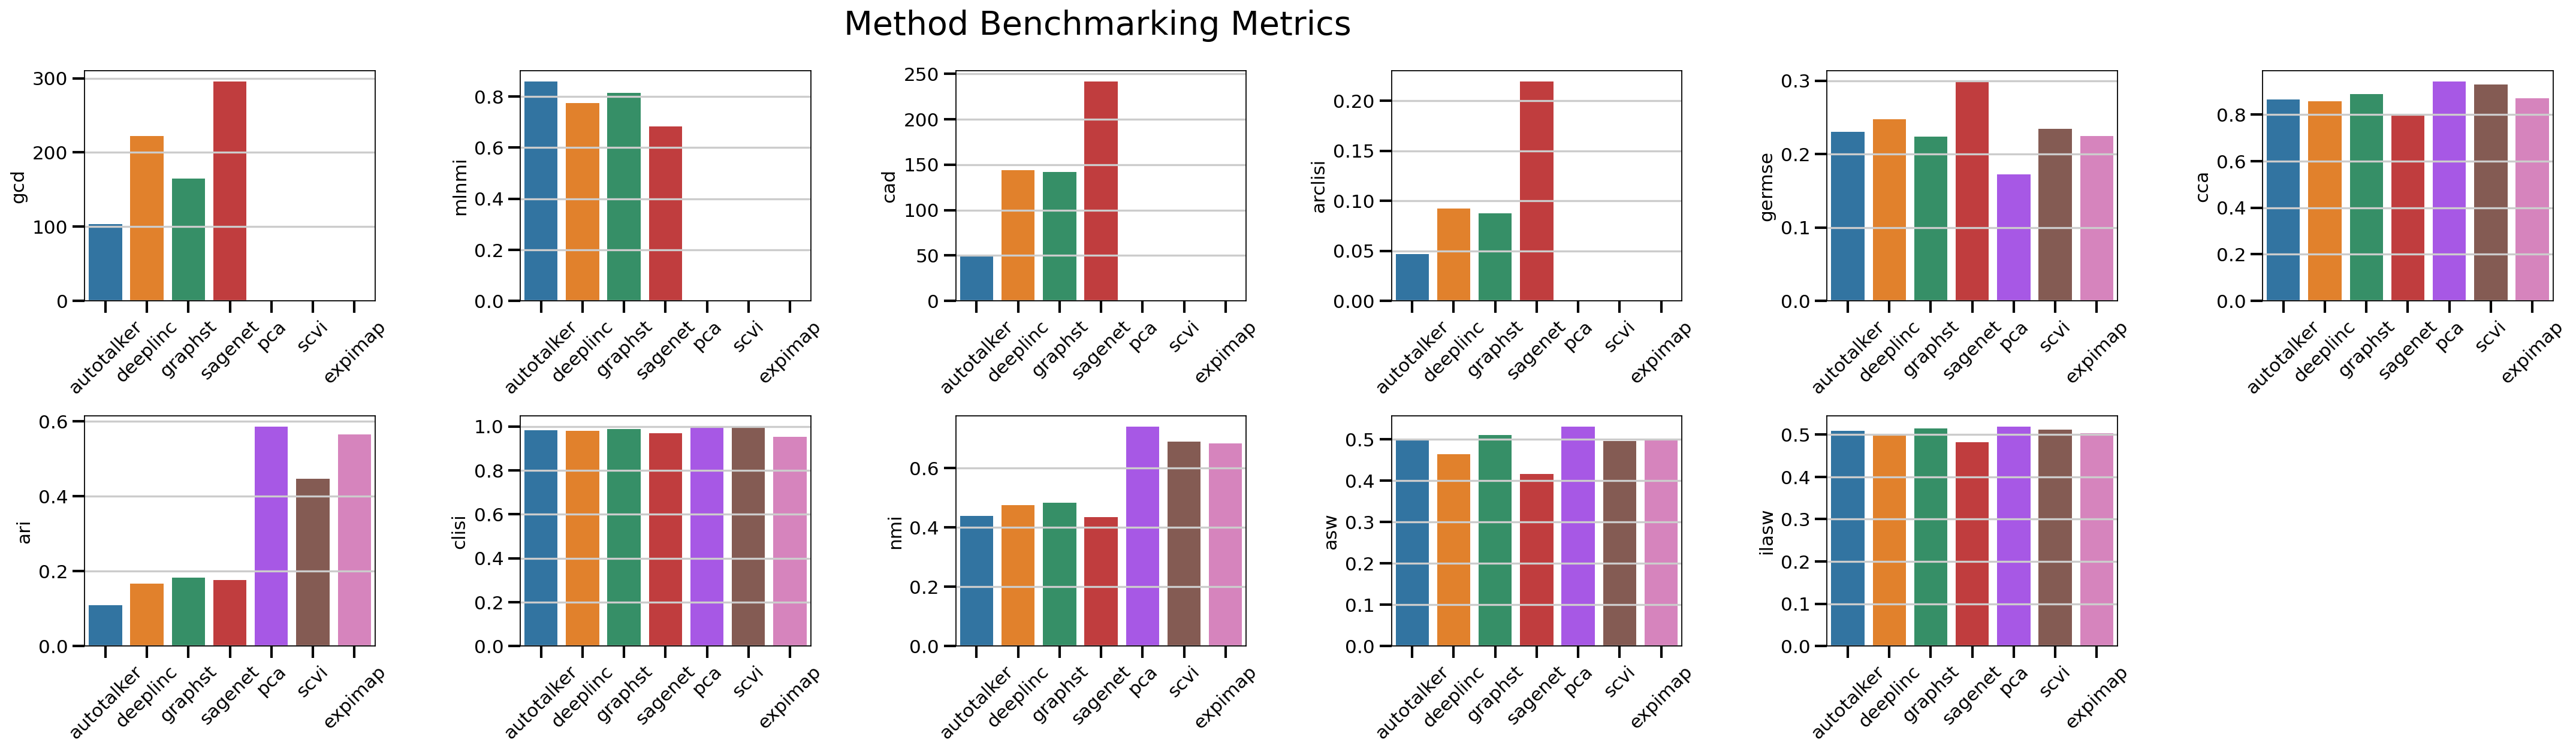

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=int(np.ceil(len(columns)/2)), figsize=(3*len(columns), 8))
axs=axs.flatten()

for i, col in enumerate(columns):
    sns.barplot(data=mean_df, x=mean_df.index, y=col, ax=axs[i])
    axs[i].set_xlabel('')
    xlabels = axs[i].get_xticks()
    axs[i].set_xticklabels(mean_df.index, rotation=45)
plt.suptitle("Method Benchmarking Metrics", fontsize=25)
plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.9)

if len(columns) % 2 != 0:
    fig.delaxes(axs[-1])

fig.savefig(f"{figure_folder_path}/metrics_{current_timestamp}.png",
            bbox_inches="tight")    
plt.show()

##### 3.2.8.1 Metrics Ranking Plot

In [16]:
mean_df_min_best = mean_df[["gcd", "cad", "arclisi", "germse"]] # lower values are better
mean_df_max_best = mean_df[["mlnmi", "cca", "ari", "clisi", "nmi", "asw", "ilasw", ]] # higher values are better
rank_df_min = mean_df_min_best.rank(method="max", ascending=True)
rank_df_max = mean_df_max_best.rank(method="max", ascending=False)
rank_df = pd.concat([rank_df_min, rank_df_max], axis=1)
rank_df = rank_df[columns]

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)


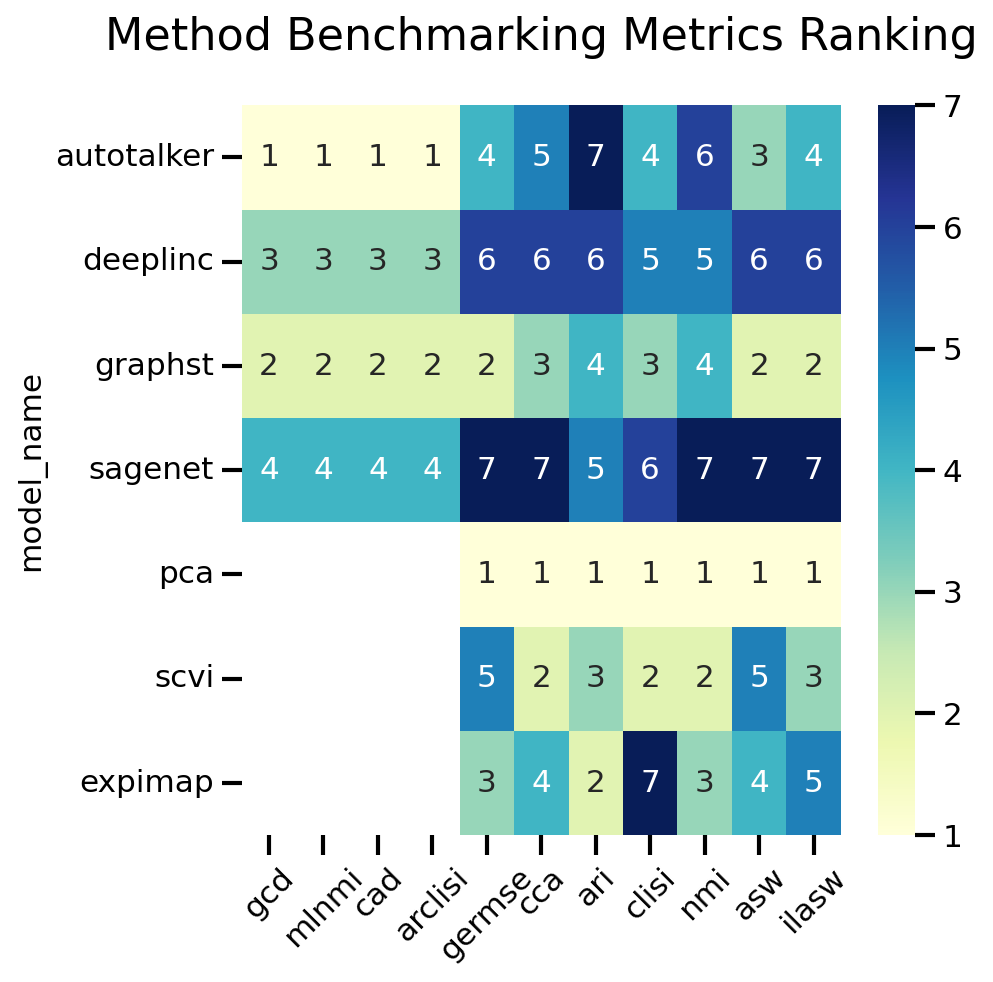

In [17]:
heatmap = sns.heatmap(rank_df, annot=True, cmap="YlGnBu")
fig = heatmap.get_figure()
plt.title("Method Benchmarking Metrics Ranking", fontsize=20, pad=25)
plt.xticks(rotation=45)
fig.savefig(f"{figure_folder_path}/metrics_ranking_{current_timestamp}.png",
            bbox_inches="tight")
plt.show()